## Import packages

In [1]:
import cv2
import pickle
from PIL import Image
from os.path import isdir
from random import choice
from sklearn.svm import SVC
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
from os import listdir,mkdir,chdir
from keras.models import load_model
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import LabelEncoder,Normalizer,LabelEncoder,Normalizer
from numpy import savez_compressed,asarray,load,expand_dims,asarray,savez_compressed,round

In [2]:
chdir('F:\Graduation Project\Computer Vision\Face Recognition')

## Face detection using MTCNN

In [3]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print(f'>loaded {len(faces)} examples for class: {subdir}')
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

# load train dataset
trainX, trainy = load_dataset('F:/Graduation Project/Computer Vision/Face Recognition/face_dataset/dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('F:/Graduation Project/Computer Vision/Face Recognition/face_dataset/dataset/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
savez_compressed('faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 12 examples for class: alaa
>loaded 12 examples for class: aravind
>loaded 21 examples for class: billgates
>loaded 17 examples for class: messi
>loaded 14 examples for class: ronaldo
>loaded 17 examples for class: stevejob
>loaded 22 examples for class: sundarpichai
(115, 160, 160, 3) (115,)
>loaded 12 examples for class: alaa
>loaded 4 examples for class: aravind
>loaded 5 examples for class: billgates
>loaded 5 examples for class: messi
>loaded 5 examples for class: ronaldo
>loaded 5 examples for class: stevejob
>loaded 5 examples for class: sundarpichai
(41, 160, 160, 3) (41,)


## Calculate a face embedding


In [4]:
# calculate a face embedding for each face in the dataset using facenet
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

In [5]:
# load the face dataset
data = load('faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (115, 160, 160, 3) (115,) (41, 160, 160, 3) (41,)
Loaded Model
(115, 128)
(41, 128)


## Develop a classifier

In [6]:
# load faces
data = load('faces-dataset.npz')
testX_faces = data['arr_2']
# load face embedding 
data = load('faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print(f'Dataset: train = {trainX.shape[0]} , test = {testX.shape[0]}')
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model_SVC = SVC(kernel='rbf' , probability=True)
model_SVC.fit(trainX, trainy)
# predict
yhat_train = model_SVC.predict(trainX)
yhat_test = model_SVC.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print(f'Accuracy: train = {score_train*100} , test = {score_test*100}')
pickle.dump(model_SVC, open('model_svc.pkl', 'wb'))

Dataset: train = 115 , test = 41
Accuracy: train = 100.0 , test = 100.0


Predicted: billgates  80.0
Expected: billgates


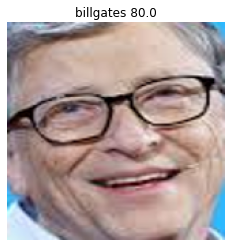

In [9]:
# test model on a random example from the test dataset
#selection = choice([i for i in range(testX.shape[0])])
selection=20
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model_SVC.predict(samples)
yhat_prob = model_SVC.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print(f'Predicted: {predict_names[0]}  {round(class_probability)}')
print(f'Expected: {random_face_name[0]}')

# plot for fun
import matplotlib.image as img
import matplotlib.pyplot as plt
#testImage = img.imread('/content/my_dataset/dataset/val/billgates/images.jpg')
  
# displaying the image
#plt.imshow(testImage)
#pyplot.axis('off')
#pyplot.show()
pyplot.imshow(random_face_pixels)
title = f'{predict_names[0]} {round(class_probability)}'
pyplot.title(title)
pyplot.axis('off')
pyplot.show()